# Deriving a vegetation index from PlanetScope imagery

Researchers often use a vegetation index called NDVI to measure a landscape's "greeenness" or density of healthy vegetation. NDVI (Normalized Difference Vegetation Index), developed by a NASA scientist named Compton Tucker in 1977, can show the difference between water and plants, bare soil and grass, whether plants are under stress, and what lifecycle stage a crop is in. It compares how much more near-infrared light is reflected by chlorophyll vs visible red light. NDVI is expressed as the following equation:

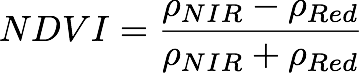

NDVI values are derived from satellite imagery that captures data in visibile and near-infrared wavelengths. "If there is much more reflected light in near-infrared wavelengths than in visible wavelengths, then the vegetation in that pixel is likely to be dense," [according to NASA researchers](https://earthobservatory.nasa.gov/Features/MeasuringVegetation/measuring_vegetation_1.php). You can [read more](https://phenology.cr.usgs.gov/ndvi_foundation.php) about how NDVI is used by scientists to study cyclical, seasonal, and long-term changes in plant health and climate. 

In this guide, we'll use Python's numpy library to perform a basic NDVI calculation on PlanetScope 4-band imagery.

### Here are the steps we'll take:

1. Download a 4-Band image
2. Extract the Visible Red, and NIR bands
3. Normalize to Top of Atmosphere Reflectance
4. Perform the NDVI calculation
5. Save the NDVI image
6. Apply a color map

### Requirements
- Python 2.7 or 3+
- [Planet's Python Client](https://www.planet.com/docs/api-quickstart-examples/cli/)
- rasterio
- numpy
- matplotlib
- retrying
- requests
- A Planet API Key, stored as environment variable `$PL_API_KEY`.
- Planet 4-Band Imagery with the following specificatios: `item-type`: PSOrthoTile, REOrthoTile, PSScene4Band; `asset-type`: analytic, basic_analytic

## Step 1. Download a 4-Band image 

First, we're going to download a 4-band PlanetScope satellite image of agricultural land in California's Central Valley, captured in late August 2016 (id: 20160831_180302_0e26). 

You can do this using [Planet's Python client](https://www.planet.com/docs/api-quickstart-examples/cli/) to interact with our Data API, or by browsing [Planet Explorer](https://www.planet.com/products/explorer/), filtering for '4 Band PlanetScope scene' (PSScene4Band) or 'Planetscope ortho tile' (PSOrthoTile), and downloading an 'analytic' asset.

Before we download the image, we're going to preview a thumbnail via Planet's Data API. (The thumbnails are 256x256 by default, and can be scaled up to 512x512 by passing in a `width` parameter.) 

In [6]:
from IPython.display import Image
Image(url="https://api.planet.com/data/v1/item-types/PSScene4Band/items/20160831_180302_0e26/thumb?width=512")

Next we're going to use the Planet's Python client to download the image. *Note: when you run this command, you'll get a stream of update messages in your Jupyter notebook as the client polls the Data API to see if the image is activated and ready to download.*

In [ ]:
!planet data download --item-type PSScene4Band --asset-type analytic,analytic_xml --string-in id 20160831_180302_0e26

activating: 0            complete: 0              elapsed: 0                    
paging: False            pending: 0                                             

activating: 0            complete: 0              elapsed: 1                    
paging: False            pending: 0                                             

activating: 0            complete: 0              elapsed: 2                    
paging: False            pending: 0                                             

activating: 0            complete: 0              elapsed: 3                    
paging: False            pending: 0                                             

activating: 0            complete: 0              elapsed: 4                    
paging: False            pending: 0                                             

activating: 0            complete: 0              elapsed: 5                    
paging: False            pending: 0                                             

activating: 0         

activating: 0            complete: 0              downloaded: 0.00MB            
downloading: 2           elapsed: 33              paging: False                 
pending: 0                                                                      

activating: 0            complete: 0              downloaded: 0.00MB            
downloading: 2           elapsed: 34              paging: False                 
pending: 0                                                                      

activating: 0            complete: 0              downloaded: 0.00MB            
downloading: 2           elapsed: 35              paging: False                 
pending: 0                                                                      

activating: 0            complete: 0              downloaded: 0.00MB            
downloading: 2           elapsed: 36              paging: False                 
pending: 0                                                                      

activating: 0           

**Congratulations!** You now have two files in your download directory: `20160831_180302_0e26_3B_AnalyticMS.tif` and `20160831_180302_0e26_3B_AnalyticMS_metadata.xml`. 

## Step 2. Extract the Visible and NIR bands 

In this step, we're going to open the raster image we downloaded (the .tif file), extract the visible and near-infrared bands, and return a numpy array. In PlanetScope 4-band images, the band order is BGRN: Blue, Green, Red, Near-infrared.

In [ ]:
import rasterio
import numpy

filename = "20160831_180302_0e26_3B_AnalyticMS.tif"

# Load red and NIR bands - note all PlanetScope 4-band images have band order BGRN
with rasterio.open(filename) as src:
    band_red = src.read(3)

with rasterio.open(filename) as src:
    band_nir = src.read(4)

## Step 3. Normalize to Top of Atmosphere Reflectance

We must normalize the values in the bands so that the NDVI calculation yield values in the expected range. 

In [ ]:
from xml.dom import minidom

xmldoc = minidom.parse("20160831_180302_0e26_3B_AnalyticMS_metadata.xml")
nodes = xmldoc.getElementsByTagName("ps:bandSpecificMetadata")

# XML parser refers to bands by numbers 1-4
coeffs = {}
for node in nodes:
    bn = node.getElementsByTagName("ps:bandNumber")[0].firstChild.data
    if bn in ['1', '2', '3', '4']:
        i = int(bn)
        value = node.getElementsByTagName("ps:reflectanceCoefficient")[0].firstChild.data
        coeffs[i] = float(value)
        
# Multiply the band values by the TOA reflectance coefficients
band_red = band_red * coeffs[3]
band_nir = band_nir * coeffs[4]

## Step 4. Perform the NDVI calculation

Next we perform the NDVI calculation through subtraction and division of the pixel values.

In [ ]:
# Allow division by zero
numpy.seterr(divide='ignore', invalid='ignore')

# Calculate NDVI. This is the equation at the top of this guide expressed in code
ndvi = (band_nir.astype(float) - band_red.astype(float)) / (band_nir + band_red)


## Step 5. Save the NDVI image 

Finally we output these new pixel values to a new image file, making sure we mirror the GeoTIFF spatial metadata:

In [ ]:
# Set spatial characteristics of the output object to mirror the input
kwargs = src.meta
kwargs.update(
    dtype=rasterio.float32,
    count = 1)

# Write band calculations to a new raster file
with rasterio.open('ndvi.tif', 'w', **kwargs) as dst:
        dst.write_band(1, ndvi.astype(rasterio.float32))

## Step 6. Apply a color map

In [ ]:
import matplotlib.pyplot as plt
img = plt.imsave("ndvi_cmap.png", ndvi, cmap=plt.cm.summer)

In [ ]:
from IPython.display import HTML 
HTML('<img src="ndvi_cmap.png" width=75%>') 

## 7. Show a histogram of NDVI values

### How can we interpret NDVI values?
* Values are typicalled scaled to range from -1.0 to 1.0:
* water ~ -1.0
* barren area ~ 0.0
* shrub/grass ~ 0.2-0.4
* forest ~ 1.0

In [11]:
import numpy.ma as ma

# Create a histogram function
def rasterHistogram(raster_matrix):
    '''Accepts matrix and generates histogram'''
     
    # Line above is function docstring
    # Flatten 2d-matrix
    flat_raster = ma.compressed(raster_matrix)
     
    # Setup the plot (see matplotlib.sourceforge.net)
    fig = plt.figure(figsize=(8,11))
    ax = fig.add_subplot(1,1,1)
     
    # Plot histogram
    ax.hist(flat_raster, 10, normed=0, histtype='bar',
            align='mid')
    # Show the plot on screen
    plt.show()

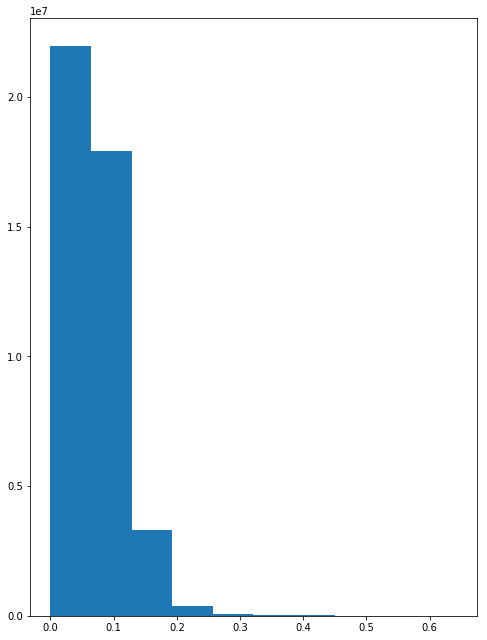

In [12]:
# Pass matrix representation of raster to function
rasterHistogram(band_red)
# Shows histogram on screen